<a href="https://colab.research.google.com/github/DPariser/DataScience/blob/main/Preprocessing/042923_DNP2_QC_and_Pre_Processing_FASTQ_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plese DO NOT RUN THIS
## Re-running this will override the files existing in the google drive. Please use as a VIEW ONLY.
Please use this as a reference: https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/kb_building_atlas/python/kb_analysis_0_python.ipynb#scrollTo=_53je7n16_pc

# Setup Environment

This Notebook is created fresh with nothing else installed explicitly besides what is shown. So we assume that if you follow the instruction exactly, it should run out of the box.

In [1]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

In [2]:
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install scanpy
!pip install anndata
!pip3 install leidenalg

In [3]:
# Install packages for analysis and plotting
from scipy.io import mmread
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scanpy as sc
import anndata
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from scipy.sparse import csr_matrix
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

In [4]:
%%time
%%capture
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python==0.24.1

CPU times: user 58.7 ms, sys: 9.45 ms, total: 68.1 ms
Wall time: 7.84 s


## ❗**Connect to the Data**

The data is stored on a shared location in Google Drive. Since many of the files are very large and thus it is not feasable to download them to a location and use them. One good way of dealing with this situation is to create a shortcut to your own Google Drive and point to the shortcut and use them just like they are your own files on Google Drive. Here is the instruction how to set this up.

* Click on the link to the share location of the data.
* Nevigate to the "Data files" folder.
* Click on the "Dropdown" arrow right next to the breaksrumb on the top right.
* Choose "Add shortcut to Drive".

Now it should appear in your Google Drive as the "Data files" folder.
You can now connect to your Google Drive and access the file.
From this point on, we assume that you have the Google Drive setup this way.

Let's mount the Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google drive root
gd_root = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics"

# Data roots
patient_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149/HRR339729"
lungmk_root = f"{gd_root}/H17_LungMk/LungMk"

# Working directories
patient_dir = f"{patient_root}"
lungmk_dir = f"{lungmk_root}"

# Create the directories if they don't exist
!mkdir -p "{patient_dir}"
!mkdir -p "{lungmk_dir}"

# List the contents of the directories
print("Contents of patient directory:")
!ls "{patient_dir}"
print("\nContents of LungMk directory:")
!ls "{lungmk_dir}"

Contents of patient directory:
10xv2_whitelist.txt		 HRR339729_r2.fastq.gz	output.bus
counts_unfiltered		 HRR339729_sta.xml	output.unfiltered.bus
filtered_normalized_counts.h5ad  inspect.json		run_info.json
HRR339729_f1.fastq.gz		 matrix.ec		transcripts.txt

Contents of LungMk directory:
10xv2_whitelist.txt  inspect.json	    run_info.json
counts_unfiltered    matrix.ec		    t2g.txt
GRCh38genome.idx     output.bus		    transcripts.txt
index.idx	     output.unfiltered.bus  v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [ ]:
# Check if the directories exist
if os.path.exists(lungmk_dir):
    print(f"The directory {lungmk_dir} exists.")
else:
    print(f"The directory {lungmk_dir} does not exist.")

if os.path.exists(patient_dir):
    print(f"The directory {patient_dir} exists.")
else:
    print(f"The directory {patient_dir} does not exist.")

The directory /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/LungMk exists.
The directory /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149/HRR339729 exists.


# Quality Control

## need to edit this for looping

* https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/kb_getting_started/python/kb_intro_2_python.ipynb

## Filtering cells based on count
Preliminary counts were then used for downstream analysis. Quality control was applied to cells based on three metrics step by step: the total UMI counts, number of detected genes and proportion of mitochondrial gene counts per cell. Specifically, cells with less than 1500 UMI counts and 500 detected genes were filtered, as well as cells with more than 10% mitochondrial gene counts. 

## Remove potential doublets (double balloon effect)

This is what the investigators did in the original paper:


*   To remove potential doublets, for PBMC samples, cells with UMI counts above 25,000 and detected genes above 5,000 are filtered out. For other tissues, cells with UMI counts above 70,000 and detected genes above 7,500 are filtered out. Additionally, we applied Scrublet (Wolock et al., 2019 link text) to identify potential doublets. The doublet score for each single cell and the threshold based on the bimodal distribution was calculated using default parameters. The expected doublet rate was set to be 0.08, and cells predicted to be doublets or with doubletScore larger than 0.25 were filtered. After quality control, a total of 1,598,708 cells were remained.
*   for now we will not be using onliy the PBMC filter methods applied to all tissues
*  *We may revisit this later*

## Normalize
For normalization of UMI counts, the Scanpy package provides several normalization methods, including the Total Count Normalization (TCN) and Normalization by Logarithm (LogNormalize) methods, which are commonly used in single-cell RNA-seq analysis. Here, we first load the count matrix using Scanpy's read_text function. We then normalize the data using the normalize_total function, which scales the counts for each cell so that they have the same total count (in this case, 10,000). We then scale the data by cell-specific size factors using the scale function, and logarithmically transform the data using the log1p function.

# DO NOT RUN THIS UNLESS NEEDED!
This code is to delete the post-processed .ha5d file if a new one needs to be created for any reason

In [ ]:
import os

# Google drive root
gd_root = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics"

# Data roots
data_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149"
lungmk_root = f"{gd_root}/H17_LungMk/LungMk"

# Working directories
data_dir = f"{data_root}"
lungmk_dir = f"{lungmk_root}"

# Create the directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(lungmk_dir, exist_ok=True)

# List the contents of the directories
print("Contents of data directory:")
!ls "{data_dir}"
print("\nContents of LungMk directory:")
!ls "{lungmk_dir}"

# Loop through the patients
patient_ids = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for patient_id in patient_ids:
    # Patient directories
    patient_root = f"{data_dir}/{patient_id}"
    patient_dir = f"{patient_root}"
    
    # Check if the file exists and delete it
    filtered_normalized_counts_file = f"{patient_dir}/filtered_normalized_counts.h5ad"
    if os.path.exists(filtered_normalized_counts_file):
        print(f"Deleting {filtered_normalized_counts_file}")
        os.remove(filtered_normalized_counts_file)
        print("File deleted.")
    else:
        print(f"File {filtered_normalized_counts_file} does not exist.")


# DO NOT RUN THIS UNLESS NEEDED!
This code is to delete the post-processed .ha5d file if a new one needs to be created for any reason

In [ ]:
# Identify all the patients so we can loop through them in the cell below
folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Print the directories
print(directories)

# Use the directories as patient_ids
patient_ids = directories

for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    patient_dir = f"{patient_root}"
    
    # Create the directory if it doesn't exist
    !mkdir -p "{patient_dir}"
    
    # Check if the directory exists
    if os.path.exists(patient_dir):
        print(f"The directory {patient_dir} exists.")
    else:
        print(f"The directory {patient_dir} does not exist.")
        
# Function to filter and normalize the data based on the given criteria
def filter_and_normalize_data(patient_dir):
    try:
        adata = sc.read_mtx(f"{patient_dir}/counts_unfiltered/cells_x_genes.mtx")
        adata.var_names = pd.read_csv(f"{patient_dir}/counts_unfiltered/cells_x_genes.genes.txt", header=None, sep='\t')[0]
        adata.obs_names = pd.read_csv(f"{patient_dir}/counts_unfiltered/cells_x_genes.barcodes.txt", header=None)[0]
    except FileNotFoundError:
        print(f"File not found error encountered for patient data in {patient_dir}. Skipping.")
        return
    
    print(f"Initial number of cells: {adata.shape[0]}, Initial number of genes: {adata.shape[1]}")
    
    # Filter cells based on total UMI counts, number of detected genes, and proportion of mitochondrial gene counts per cell
    sc.pp.filter_cells(adata, min_counts=1500)
    sc.pp.filter_cells(adata, min_genes=500)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata = adata[adata.obs['percent_mito'] < 0.1, :]
    
    print(f"Number of cells after filtering by UMI counts, detected genes, and mitochondrial gene counts: {adata.shape[0]}")
    
    # Filter cells based on potential doublets
    sc.pp.filter_cells(adata, max_counts=25000)
    sc.pp.filter_cells(adata, max_genes=5000)
    
    print(f"Number of cells after filtering by potential doublets: {adata.shape[0]}")
    
    if adata.shape[0] == 0:
        print(f"No cells remaining after filtering for patient data in {patient_dir}. Skipping.")
        return
    
    try:
        # Normalize the data using Total Count Normalization (TCN) method
        sc.pp.normalize_total(adata, target_sum=1e4)

        # Logarithmically transform the data
        sc.pp.log1p(adata)

        # Scale the data by cell-specific size factors
        sc.pp.scale(adata)

    except ZeroDivisionError:
        print(f"ZeroDivisionError encountered for patient data in {patient_dir}. Skipping.")
        return
    
    # Calculate the remaining number of cells after filtering
    num_cells = adata.shape[0]
    print(f"Number of cells remaining after filtering: {num_cells}")

    # Save the filtered and normalized data in the patient's original folder
    adata.write(f"{patient_dir}/filtered_normalized_counts.h5ad")

# Loop through each patient and filter and normalize the data
for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    print(f"Processing patient {patient_id}")

    # Check if the filtered and normalized counts file already exists
    filtered_normalized_counts_file = f"{patient_root}/filtered_normalized_counts.h5ad"
    if os.path.exists(filtered_normalized_counts_file):
        print(f"Filtered and normalized counts file for patient {patient_id} already exists. Skipping.")
        continue

    # If the filtered and normalized counts file doesn't exist, process, filter and normalize the data
    filter_and_normalize_data(patient_root)

## Combine all patient files into one combine data file (.ha5d)
## Do not run
This requires too much ram and thus cannot be run on Google Drive


In [ ]:
import os
import scanpy as sc
import anndata

# Identify all the patients so we can loop through them
folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Use the directories as patient_ids
patient_ids = directories

chunk_size = 5  # Define the size of the chunks
chunks = [patient_ids[i:i + chunk_size] for i in range(0, len(patient_ids), chunk_size)]

combined_data = None

for i, chunk in enumerate(chunks):
    adatas = []
    for patient_id in chunk:
        patient_root = f"{folder_path}/{patient_id}"
        patient_dir = f"{patient_root}"

        # Load the filtered and normalized data for each patient
        filtered_normalized_file = f"{patient_dir}/filtered_normalized_counts.h5ad"
        try:
            adata = sc.read(filtered_normalized_file)  # Load data into memory
        except FileNotFoundError:
            print(f"File not found error for patient {patient_id}. Skipping.")
            continue

        # Append the adata to the list
        adatas.append(adata)

    # Concatenate the Anndata objects
    chunk_data = anndata.concat(adatas, join='outer')

    # If this is the first chunk, assign it to combined_data
    if combined_data is None:
        combined_data = chunk_data
    else:
        # If this is not the first chunk, concatenate it with the existing combined_data
        combined_data = anndata.concat([combined_data, chunk_data], join='outer')

    # Delete the adatas and chunk_data variables to free up memory
    del adatas
    del chunk_data

# Save the combined data to a file
combined_data_file = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/combined_data.h5ad"
combined_data.write(combined_data_file)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Step 1: Extract patient IDs from XML files
### List XML contents

In [ ]:
folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Use the directories as patient_ids
patient_ids = directories

for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    xml_file_path = f"{patient_root}/{patient_id}_sta.xml"

    if not os.path.exists(xml_file_path):
        print(f"XML file not found for patient {patient_id}. Skipping.")
        continue
    
    # Example diagnostic: Print the contents of the XML file
    with open(xml_file_path, "r") as xml_file:
        xml_contents = xml_file.read()
        print(f"XML file contents for patient {patient_id}:\n{xml_contents}")

XML file contents for patient HRR339728:
<Run accession="/p300/HRA-Process/temp/HRA001149/HRR339728/" read_length="fixed" spot_count="195976958" base_count="25085050624" 
base_count_bio="25085050624" spot_count_mates="195976958" base_count_bio_mates="25085050624" spot_count_bad="0" base_count_bio_bad="0" spot_count_filtered="0" 
base_count_bio_filtered="0" cmp_base_count="25085050624">
  <Size value="63888488308" units="bytes"/>
  <Bases cs_native="false" count="25085050624">
    <Base value="A" count="6611588470"/>
    <Base value="C" count="6657582281"/>
    <Base value="G" count="5675080052"/>
    <Base value="T" count="6132734670"/>
    <Base value="N" count="8065151"/>
  </Bases>
  <GC-Content="49.16%"/>
  <AlignInfo>
  </AlignInfo>
  <Statistics nreads="2" nspots="195976958">
    <Read index="0" count="195976958" average="28" stdev="0"/>
    <Read index="1" count="195976958" average="100" stdev="0"/>
  </Statistics>
  <QualityCount>
<Quality value="0" count="8065151"/>
<Quality v

### Preform XML diagnostics

In [ ]:
import xml.etree.ElementTree as ET

folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List the directories in the folder
directories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Use the directories as patient_ids
patient_ids = directories

for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    xml_file_path = f"{patient_root}/{patient_id}_sta.xml"

    if not os.path.exists(xml_file_path):
        print(f"XML file not found for patient {patient_id}. Skipping.")
        continue

    # Perform diagnostics on the XML file
    try:
        # Parse the XML file
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Inspect the structure of the XML file
        print(f"XML file structure for patient {patient_id}:")
        print(f"Root element: {root.tag}")

        # Example: Print the attributes of the first child element
        if len(root) > 0:
            first_child = root[0]
            print(f"Attributes of the first child element:")
            for attr in first_child.attrib:
                print(f"- {attr}: {first_child.attrib[attr]}")
        else:
            print("XML file has no child elements.")

    except ET.ParseError as e:
        print(f"Error parsing XML file for patient {patient_id}: {e}")


Error parsing XML file for patient HRR339728: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339729: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339730: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339731: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339732: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339733: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339734: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339735: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339736: not well-formed (invalid token): line 12, column 13
Error parsing XML file for patient HRR339737: not well-formed (invalid token): line 12, column 13
Error parsing XML fi

NOTE: We need to cautious when making corrections to XML files as any changes may affect the validity and intended interpretation of the data. We should consult the XML specification and have a clear understanding of the XML structure and expected content before making modifications.

Instead I will pull the IDs from Google Drive directly.

### Pull Patient IDs

In [ ]:
# Google Drive root
gd_root = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics"

# Data root
data_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149"

# Get the patient IDs from the directories in the data root
patient_ids = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]

# Print the patient IDs
for patient_id in patient_ids:
    print(patient_id)

HRR339728
HRR339729
HRR339730
HRR339731
HRR339732
HRR339733
HRR339734
HRR339735
HRR339736
HRR339737
HRR339738
HRR339740
HRR339739
HRR339741
HRR339743
HRR339748
HRR339753
HRR339751
HRR339752
HRR339755
HRR339756
HRR339754
HRR339749
HRR339750
HRR339742
HRR339746
HRR339747
HRR339744
HRR339759
HRR339757
HRR339761
HRR339760
HRR339762
HRR339765
HRR339764
HRR339763
HRR339770
HRR339769
HRR339771
HRR339772
HRR339775
HRR339777
HRR339774
HRR339776
HRR339773
HRR339778
HRR339781 (2)
HRR339782 (2)
HRR339783 (2)
HRR339784 (1)
HRR339786 (1)
HRR339785 (1)
HRR339786
HRR339787
HRR339795
HRR339766
HRR339767
HRR339768
HRR339790
HRR339791
HRR339792
HRR339789
HRR339788
HRR339758
HRR339794
HRR339793
HRR339805
HRR339801
HRR339802
HRR339799
HRR339804
HRR339803
HRR339798
HRR339797
HRR339796
HRR339800
HRR339808
HRR339806
HRR339815
HRR339812
HRR339811
HRR339814
HRR339807
HRR339813
HRR339810
HRR339809
HRR339816
HRR339824
HRR339821
HRR339823
HRR339822
HRR339817
HRR339819
HRR339820
HRR339825
HRR339818
HRR339830
HRR339

### Step 2: Combine barcodes files
#### 2.1 Create the combine barcodes


In [ ]:
# Google Drive root
gd_root = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics"

# Data root
data_root = f"{gd_root}/H17_LungMk/Data_files/HRA001149"

combined_barcodes = []

# Loop through each patient's directory
for patient_dir in os.listdir(data_root):
    # Construct the path to the barcodes file for this patient
    barcode_file_path = os.path.join(data_root, patient_dir, "counts_unfiltered/cells_x_genes.barcodes.txt")

    # Check if the barcodes file exists
    if os.path.isfile(barcode_file_path):
        # Load the barcodes as a pandas DataFrame
        df = pd.read_csv(barcode_file_path, header=None)

        # Prepend the patient ID to each barcode
        df[0] = f"{patient_dir}_" + df[0]

        # Append these barcodes to the combined list
        combined_barcodes.extend(df[0].tolist())

# Specify the path to save the combined barcode file
output_dir = f"{gd_root}/H17_LungMk/Combined_Data"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}/combined_barcodes.txt"

# Write the combined barcodes to the output file
with open(output_file, "w") as f:
    for barcode in combined_barcodes:
        f.write(f"{barcode}\n")

print(f"Combined barcode file saved at: {output_file}")

Combined barcode file saved at: /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Combined_Data/combined_barcodes.txt


#### 2.2 Check that the file works

In [ ]:
# Specify the path to the combined barcode file
combined_barcodes_file = '/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Combined_Data/combined_barcodes.txt'

# Check if the file exists
if os.path.isfile(combined_barcodes_file):
    # Load the file as a pandas DataFrame
    df = pd.read_csv(combined_barcodes_file, header=None)

    # Check the format and quality of the data
    is_valid = True

    # Check if the DataFrame has any missing values
    if df.isnull().values.any():
        print("Error: The combined barcode file contains missing values.")
        is_valid = False

    # Check if the DataFrame has the correct number of columns
    expected_columns = 1
    if df.shape[1] != expected_columns:
        print(f"Error: The combined barcode file should have {expected_columns} column(s).")
        is_valid = False

    # Check if the DataFrame has any duplicate values
    if df.duplicated().any():
        print("Error: The combined barcode file contains duplicate values.")
        is_valid = False

    # Check if the DataFrame has any unexpected characters or patterns
    # Add any additional checks specific to your barcode format

    if is_valid:
        print("The combined barcode file is well-formatted and can be used.")
else:
    print("Error: The combined barcode file does not exist.")


The combined barcode file is well-formatted and can be used.


### Step 3: Combine genes files
#### 3.1 Create the combine genes
Please note that this assumes all the gene files are identical across all patients -- I assume this is the correct way to do this.

In [ ]:
# Step 3: Combining Gene Files

combined_genes = []

# Loop through each patient's directory
for patient_dir in os.listdir(data_root):
    # Construct the path to the genes file for this patient
    gene_file_path = os.path.join(data_root, patient_dir, "counts_unfiltered/cells_x_genes.genes.txt")

    # Check if the genes file exists
    if os.path.isfile(gene_file_path):
        # Load the genes as a pandas DataFrame
        df = pd.read_csv(gene_file_path, header=None)

        # Append these genes to the combined list
        combined_genes.extend(df[0].tolist())

# Specify the path to save the combined gene file
output_file_genes = f"{output_dir}/combined_genes.txt"

# Write the combined genes to the output file
with open(output_file_genes, "w") as f:
    for gene in combined_genes:
        f.write(f"{gene}\n")

print(f"Combined gene file saved at: {output_file_genes}")


Combined gene file saved at: /content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Combined_Data/combined_genes.txt


#### 3.2 Check that the file works

In [ ]:
# Specify the path to the combined gene file
combined_genes_file = '/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Combined_Data/combined_genes.txt'

# Check if the file exists
if os.path.isfile(combined_genes_file):
    # Load the file as a pandas DataFrame
    df = pd.read_csv(combined_genes_file, header=None)

    # Check the format and quality of the data
    is_valid = True

    # Check if the DataFrame has any missing values
    if df.isnull().values.any():
        print("Error: The combined gene file contains missing values.")
        is_valid = False

    # Check if the DataFrame has the correct number of columns
    expected_columns = 1
    if df.shape[1] != expected_columns:
        print(f"Error: The combined gene file should have {expected_columns} column(s).")
        is_valid = False

    # Check if the DataFrame has any duplicate values
    if df.duplicated().any():
        print("Error: The combined gene file contains duplicate values.")
        is_valid = False

    if is_valid:
        print("The combined gene file is well-formatted and can be used.")
else:
    print("Error: The combined gene file does not exist.")

Error: The combined gene file contains duplicate values.


### Step 4: Combine filtered_normalized_counts.h5ad files into a single file
#### 4.1 Create the combine matrix file
This script reads each h5ad file one by one and writes its contents into the new h5 file. The chunks=True option enables automatic chunking, which allows you to extend the dataset later and is essential for efficient resizing of the dataset. The maxshape parameter allows the dataset to grow.

It's worth noting that this is a relatively low-level operation and doesn't capture all the complexity of an AnnData object. In particular, it only copies the X field (the main data matrix), not any of the annotations or auxiliary data. You might need to extend this code if you want to include more features of the h5ad files.

For when we have more RAM we should use adata and concatenate the data.

In [5]:
import h5py
import numpy as np

# Create a new h5 file
with h5py.File(f"{output_dir}/combined_data.h5", "w") as f_out:
    
    # Initialize counters
    total_cells = 0
    total_genes = None

    for patient_id in patient_ids:
        patient_root = f"{folder_path}/{patient_id}"
        print(f"Processing patient {patient_id}")

        filtered_normalized_counts_file = f"{patient_root}/filtered_normalized_counts.h5ad"
        if os.path.exists(filtered_normalized_counts_file):
            print(f"Reading the h5ad file for patient {patient_id}.")
            with h5py.File(filtered_normalized_counts_file, "r") as f_in:
                # If it's the first file, initialize the genes list
                if total_genes is None:
                    total_genes = f_in['var']['_index'].shape[0]  # assuming '_index' contains gene names

                # Append the data to the new file
                num_cells = f_in['X'].shape[0]
                start = total_cells
                end = total_cells + num_cells
                if 'X' not in f_out:
                    maxshape = (None,) + f_in['X'].shape[1:]
                    f_out.create_dataset('X', data=f_in['X'][:], chunks=True, maxshape=maxshape)
                else:
                    f_out['X'].resize((end,) + f_out['X'].shape[1:])
                    f_out['X'][start:end] = f_in['X'][:]

                total_cells = end
        else:
            print(f"Filtered and normalized counts file for patient {patient_id} does not exist. Skipping.")

print("All files processed.")

Processing patient HRR339728
Reading the h5ad file for patient HRR339728.
Processing patient HRR339729
Reading the h5ad file for patient HRR339729.
Processing patient HRR339730
Reading the h5ad file for patient HRR339730.
Processing patient HRR339731
Reading the h5ad file for patient HRR339731.
Processing patient HRR339732
Reading the h5ad file for patient HRR339732.
Processing patient HRR339733
Reading the h5ad file for patient HRR339733.
Processing patient HRR339734
Reading the h5ad file for patient HRR339734.
Processing patient HRR339735
Reading the h5ad file for patient HRR339735.
Processing patient HRR339736
Reading the h5ad file for patient HRR339736.
Processing patient HRR339737
Reading the h5ad file for patient HRR339737.
Processing patient HRR339738
Reading the h5ad file for patient HRR339738.
Processing patient HRR339740
Reading the h5ad file for patient HRR339740.
Processing patient HRR339739
Reading the h5ad file for patient HRR339739.
Processing patient HRR339741
Reading t

#### This doesn't work as well as I wanted
We need to have an h5ad file for the combined data, doing it this way loses too much information, thus we will need to wait for the combined data until we migrate over to MIT's platform. For now we will need to loop through all the patient files. 

# Perform a QC check of the counts post-filtering
## Violin plots together

Filtered and normalized counts file for patient HRR339756 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339762 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339770 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339769 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339771 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339772 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339775 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339777 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339774 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339776 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339773 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339778 does not exist. Sk

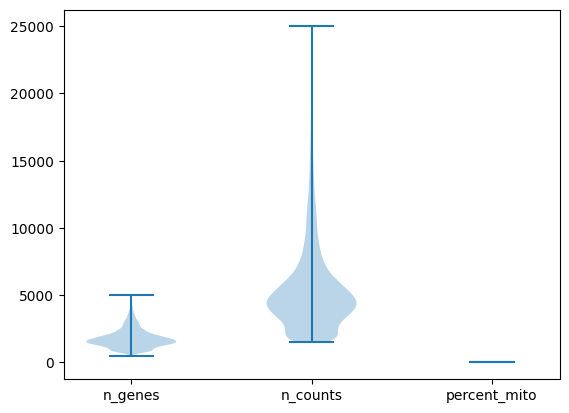

In [2]:
import scanpy as sc
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = "/content/drive/MyDrive/Pate_Lab/DNP/Bioinformatics/H17_LungMk/Data_files/HRA001149"

# List all directories (patients) in the folder
patient_ids = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Prepare a figure to plot the violin plots
fig, ax = plt.subplots()

# A dictionary to store the data for the violin plot
data_dict = {'n_genes': [], 'n_counts': [], 'percent_mito': []}

# Loop through each patient and load the AnnData object
for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    filtered_normalized_counts_file = f"{patient_root}/filtered_normalized_counts.h5ad"
    
    if os.path.exists(filtered_normalized_counts_file):
        adata = sc.read_h5ad(filtered_normalized_counts_file)
        
        # Add the data to the data_dict after resetting the index
        data_dict['n_genes'].append(adata.obs['n_genes'].reset_index(drop=True))
        data_dict['n_counts'].append(adata.obs['n_counts'].reset_index(drop=True))
        data_dict['percent_mito'].append(adata.obs['percent_mito'].reset_index(drop=True))
    else:
        print(f"Filtered and normalized counts file for patient {patient_id} does not exist. Skipping.")

# Concatenate the data in the dictionary along the vertical axis
for key in data_dict:
    data_dict[key] = pd.concat(data_dict[key], ignore_index=True)

# Convert data_dict to a DataFrame for easier plotting
data_df = pd.DataFrame(data_dict)

# Plot the violin plot using matplotlib
ax.violinplot(dataset = [data_df[col].dropna() for col in data_df])

# Set the x-axis labels
ax.set_xticks([y+1 for y in range(len(data_df.columns))])
ax.set_xticklabels(data_df.columns)

plt.show()


Filtered and normalized counts file for patient HRR339756 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339762 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339770 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339769 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339771 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339772 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339775 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339777 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339774 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339776 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339773 does not exist. Skipping.
Filtered and normalized counts file for patient HRR339778 does not exist. Sk

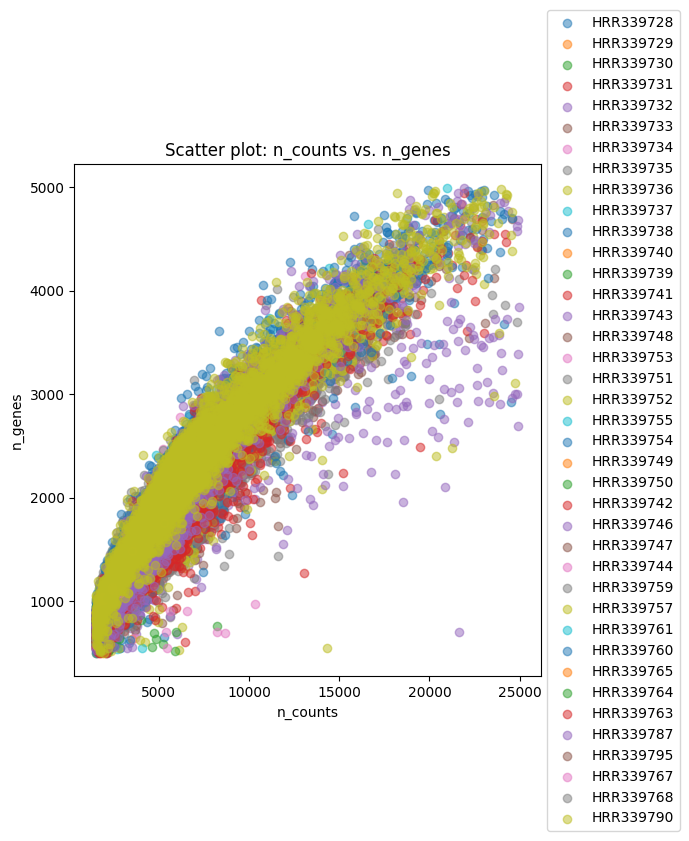

In [9]:
import matplotlib.pyplot as plt

# Create the figure and the axes
fig, axs = plt.subplots(nrows=2, figsize=(7, 14))

# Loop through each patient
for patient_id in patient_ids:
    patient_root = f"{folder_path}/{patient_id}"
    filtered_normalized_counts_file = f"{patient_root}/filtered_normalized_counts.h5ad"

    if os.path.exists(filtered_normalized_counts_file):
        adata = sc.read_h5ad(filtered_normalized_counts_file)
        
        # Scatter plot: n_counts vs. n_genes
        axs[1].scatter(adata.obs['n_counts'], adata.obs['n_genes'], alpha=0.5, label=patient_id)
    else:
        print(f"Filtered and normalized counts file for patient {patient_id} does not exist. Skipping.")

# Set labels and title for the second scatter plot
axs[1].set_xlabel('n_counts')
axs[1].set_ylabel('n_genes')
axs[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')
axs[1].set_title('Scatter plot: n_counts vs. n_genes')

# Remove the first subplot (extra graph)
fig.delaxes(axs[0])

# Display the plot
plt.tight_layout()
plt.show()